In [1]:
%matplotlib inline

In [2]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
sys.path.insert(0, '/home/mehdi/github/sysnetdev')
sys.path.insert(0, '/home/mehdi/github/LSSutils')

from lssutils.utils import hpix2radec
from lssutils.stats.nnbar import MeanDensity
from lssutils.stats.cl import get_cl as get_angularpower
from lssutils.dataviz import mycolor

import matplotlib.pyplot as plt

def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

In [3]:
# input parameters
sample = 'elg' # e.g. 'elg'
cap = 'N'    # e.g. 'N'

nside = 256



maps = ['STARDENS', 'EBV', 
      'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
      'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
      'PSFDEPTH_W1', 'PSFDEPTH_W2',
      'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']

axes = dict(zip(maps, np.arange(len(maps))))



data = ft.read(f'results/dr9m_{sample}_{cap}.fits')
npred_ = ft.read(f'results/regression/{sample}/{cap}/nn_all_{nside}/nn-weights.fits')


hpix = data['hpix'].copy()
frac = data['fracgood'].copy()
ngal = data['label'].copy()
mask = frac > 0



# mean density
nbar = {}

ix = axes['EBV']
sysm = data['features'][:, ix]

bins = np.linspace(0.00704696, 0.15544825, 10)

nbtrue = MeanDensity(ngal, frac, mask, sysm, nbins=9, binning='simple', bins=bins)
nbtrue.run()
nbar['true'] = nbtrue.output

for i in range(npred_['weight'].shape[1]):
    
    npred = np.zeros(12*nside*nside)
    npred[npred_['hpix']] = npred_['weight'][:, i]
    sf = (ngal/npred[hpix]).sum()/ngal.sum()
    wnn = npred[hpix]*sf
    wnn = wnn.clip(0.5, 2.0)

      
    nb_pred = MeanDensity(wnn*frac/sf, frac, mask, sysm, nbins=9, binning='simple', bins=bins)
    nb_pred.run()
    
    nbar['pred_%d'%i] = nb_pred.output

    print('.', end='')

....................

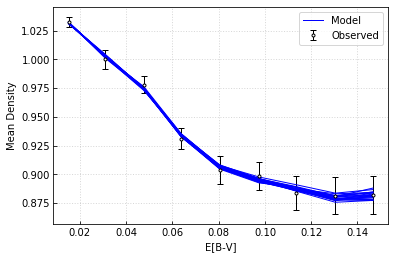

In [4]:
fig, ax = plt.subplots()

for ni, nbari in nbar.items():
    if ni=='true':
        ax.errorbar(nbari['bin_avg'], nbari['nnbar'], nbari['nnbar_err'], 
                    color='k', lw=1, marker='.', ls='None', capsize=3, mfc='w', label='Observed')
    else:
        lbl = None if ni!='pred_0' else 'Model'
        ax.plot(nbari['bin_avg'], nbari['nnbar'], 'b-', lw=1, label=lbl)
        
ax.legend()
ax.set(xlabel='E[B-V]', ylabel='Mean Density')
ax.grid(True, ls=':', lw=1, alpha=0.5)
ax.tick_params(direction='in')
# fig.savefig('model_ngal.png', dpi=300, bbox_inches='tight')